# Aplication & Utilization of global explainers
이번 장에서는 global explainer 에 대한 실습을 진행한다.  
$PV$,$PV$,$ALE$,$PI$는 모두 `alibi`를 이용하여 구현한다. `alibi`의 기본적인 문법은 다음과 같이 4가지 절차로 요약될 수 있다.  
- 필요한 explainer를 호출한다.<br>  
- 예측모형이 블랙박스 모형이면 예측함수를 정의한다.<br>
- 모형을 학습시킨 학습데이터가 필요하면 .fit step을 추가한다.<br> 
- explainer의 explain 함수를 이용하여 데이터 $X$의 explanation을 구한다.<br>


---

## PD : Partial Dependence

In [1]:
##분석에 필요한 모듈과 ablibi로부터 PartialDependence, plot_pd를 호출한다.
import warnings
warnings.filterwarnings("ignore")


import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.model_selection import train_test_split
from alibi.explainers import PartialDependence, plot_pd


다음은 $PD$와 $PV$를 적용하기 위한 bike 데이터를 불러내는 단계이다. cnt는 목적 변수로 자전거 대여수를 나타내며 설명변수 11개 중 7개는 범주형 변수임을 볼 수 있다.

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/christophM/interpretable-ml-book/master/data/bike.csv')

df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011
0,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,0
1,WINTER,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.083466,69.6087,16.652113,801,1
2,WINTER,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.229108,43.7273,16.636703,1349,2
3,WINTER,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.400000,59.0435,10.739832,1562,3
4,WINTER,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.666979,43.6957,12.522300,1600,4


alibi에 의한 Explainer의 출력이 설명 가능하도록 설명변수명, 목적변수명, 그리고 범주형 설명변수 값을 list로 제공해야 한다. 설명변수간 교호작용을 구하기 위해 설명변수는 일반적으로 index화한다. 따라서 범주형 설명변수는 dictionary  데이터로, key는 index 그리고 values는 범주값으로 정의된 list로 작성하여야 한다.  
다음은 설명변수와 목적변수명을 list 자료로 정의하고 범주형 설명변수와 실수형 설명변수를 index화 하는 과정을 보여준다.

In [3]:
feature_names = df.columns.tolist()  ## 열 이름 리스트로 저장
feature_names.remove('cnt')          ## y값은 제거

target_names = ['Number of bikes']

cat_column_names = ['season','yr','mnth','holiday','weekday','workingday','weathersit']

##alibi의 explain에서 feature option은 int로 지정해야하기 때문에 범주형,수치형 구분
##그리고 PD나 PV에서 지정하는 categorical_names는 dictionary 형태의 index

cat_column_indices = [feature_names.index(cn) for cn in cat_column_names]
num_column_indices = [feature_names.index(fn) for fn in feature_names if fn not in cat_column_names]

X = df[feature_names]
y =  df['cnt']

##train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

`OrdinalEncoder()`는 2D 텐서로 제공된 범주형 설명변수의 범주를 순서형 정수로 변환해준다. `oe_categories_` 속성을 출력해보면 mapping이 어떻게 되었는지 확인할 수 있다. `OrdinalEncoder()`를 사용하여 아래와 같이 범주형 설명변수의 index와 해당 index의 범주값으로 구성된 dictionary인 cat_names를 정의한다.

In [4]:
oe = OrdinalEncoder().fit(X_train[cat_column_names])

#범주형 변수에 ordinal encoding
X_train.loc[:,cat_column_names] = oe.transform(X_train[cat_column_names])
X_test.loc[:,cat_column_names] = oe.transform(X_test[cat_column_names])

print(X_train.head())

#numpy로 변환
X_train, y_train = X_train.to_numpy(),y_train.to_numpy()
X_test,y_test = X_test.to_numpy(), y_test.to_numpy()

#범주형 변수 mapping 정의
cat_names = {i : list(v) for (i,v) in zip(cat_column_indices,oe.categories_)}
print('-------------------------------------')
print(cat_names)

     season   yr  mnth  holiday  weekday  workingday  weathersit       temp  \
97      1.0  0.0   0.0      1.0      0.0         1.0         1.0   7.784151   
503     1.0  1.0   8.0      1.0      0.0         1.0         0.0  18.515849   
642     0.0  1.0  10.0      1.0      4.0         1.0         1.0  22.902500   
498     1.0  1.0   8.0      1.0      3.0         0.0         0.0  20.787500   
303     0.0  0.0  10.0      1.0      1.0         1.0         0.0   7.980000   

         hum  windspeed  days_since_2011  
97   83.6250  15.208464               97  
503  52.3333   9.166739              503  
642  72.2917   7.875582              642  
498  57.6250  15.082839              498  
303  70.3333   7.125450              303  
-------------------------------------
{0: ['FALL', 'SPRING', 'SUMMER', 'WINTER'], 1: [2011, 2012], 2: ['APR', 'AUG', 'DEC', 'FEB', 'JAN', 'JUL', 'JUN', 'MAR', 'MAY', 'NOV', 'OCT', 'SEP'], 3: ['HOLIDAY', 'NO HOLIDAY'], 4: ['FRI', 'MON', 'SAT', 'SUN', 'THU', 'TUE', 'WE

다음으로 `ColumnTransformer`를 이용하여 수치형 설명변수를 표준화하고 범주형 설명변수는 `OneHotEncoder`로 one-hot encoding을 실시한다.  

In [5]:
num_transf = StandardScaler()
cat_transf = OneHotEncoder(
    categories=[range(len(x)) for x in cat_names.values()],
    handle_unknown='ignore',
)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transf, cat_column_indices),
        ('num', num_transf, num_column_indices),
    ],
    sparse_threshold=0
)

<div style="border: 2px solid rgb(233, 224, 222); padding: 10px; background-color: rgb(233, 224, 222); margin: 10px 0;">
    <strong style="font-weight: bold;">● Tree model에서의 StandardScaler</strong><br>
    트리 모델은 데이터의 Scale에 민감하지 않으므로 굳이 표준화가 필요없다. 물론 표준화를 진행한다고 크게 잘못된 것은 아니다. 여기선 Alibi에서 구현한 예제의 재현성을 위해 예제와 동일하게 표준화를 진행한다. <br>
    <a href="https://docs.seldon.io/projects/alibi/en/latest/examples/pdp_regression_bike.html" target="_blank">Alibi PD example</a>
</div>

<div style="border: 2px solid rgb(233, 224, 222); padding: 10px; background-color: rgb(233, 224, 222); margin: 10px 0;">
    <strong style="font-weight: bold;">● Tree model에서 범주형 변수 Encoding 주의사항</strong><br>
    <b>Tree model을 사용할 때 범주형 변수를 처리하기 위해 One-hot Encoding은 사용하지 않는 것이 권장된다</b>. 먼저 One-hot Encoding의 자체적인 문제점을 애기하자면, 하나의 범주형 변수가 가질 수 있는 범주의 개수가 많은 경우를 High-Cardinality라고 한다. 그러한 열에 One-hot encoding을 실시하면 0과 1로 이루어진 열들이 범주의 개수만큼 늘어난다. 예를 들어 미국의 주(State) 이름이 적힌 하나의 범주형 변수에 One-hot Encoding을 실시하면 49개의 열이 추가된다. 하나의 열이 0-1로 이루어진 50개의 희박한(Sparse) 열들로 늘어나 <b>차원의 저주(Curse of dimension)</b> 문제가 발생한다. 그리고 One-hot Encoding은 하나의 변수를 여러 개의 개별적인 변수로 나누어 내재된 중요한 데이터 구조를 없애버릴 수도 있다. 추가적으로 트리 모델에서는 다음과 같은 문제들을 야기할 수 있다.<br><br>
    1. <b>잘못된 중요도 평가</b><br>
    One-hot Encoding을 적용하면 범주형 변수의 각 범주가 독립된 변수로 나뉘어, 모델이 변수의 실제 중요도를 제대로 평가하지 못할 수 있다. 이로 인해, 실제로 범주형 변수가 분할에 있어서 중요한 변수임에도, 연속형 변수보다 낮은 변수 중요도를 보일 수 있다.<br><br>
    2. <b>균등한 분할 문제</b><br>
    Tree 모델은 One-hot Encoding된 변수를 처리할 때, 각 범주에 대해 균등한 분할을 시도할 수 있다. 이는 데이터의 분포를 왜곡하고, 모델이 특정 패턴을 제대로 학습하지 못하게 할 수 있다.<br><br>
    3. <b>복잡한 트리 구조</b><br>
    One-hot Encoding으로 생성된 다수의 변수가 트리의 깊이를 증가시키고, 불필요한 분기를 하여 복잡한 구조를 만들 수 있다. 이는 학습과 예측 속도를 저하시킬 수 있다.<br><br>
    따라서 순서가 없는 범주형 변수인 경우엔 <b>Label encoding</b>이나 <b>Ordinal encoding</b>이 권장되며, XGBoost,LightGBM과 같은 다른 트리 모델들은 범주형 변수를 모델 학습 과정 중에 내부적으로 변환시켜주기도 한다.
    하지만 sklearn에서 제공하는 트리 모델들은 Encoding을 실시해야 한다. 만약 범주형 변수가 가지는 범주의 개수가 적으면 크게 문제가 되진 않을수도 있다. 해당 예시에서 마찬가지로 재현성을 위해 그대로 진행한다. <br><br>
    더 구체적인 내용이 궁금하면 해당 <a href="https://notebook.community/roaminsight/roamresearch/BlogPosts/Categorical_variables_in_tree_models/categorical_variables_post" target="_blank">자료</a>를 살펴보면 된다.
</div>


In [6]:
preprocessor.fit(X_train)

X_train_ohe = preprocessor.transform(X_train)
X_test_ohe = preprocessor.transform(X_test)

이제 Random forest 모형의 예측 결과에 대한 explainer를 구하기 위해 먼저 학습을 시킨다.

In [7]:
predictor= RandomForestRegressor(random_state=0)
predictor.fit(X_train_ohe,y_train)

##결정계수 (R^2)
print(predictor.score(X_test_ohe,y_test))

0.9014951906203503


Alibi의 $PD$는 블랙박스 모형을 가정하므로 아래와 같이 예측함수 predict_fn을 정의하고 있다.

In [8]:
prediction_fn = lambda x: predictor.predict(preprocessor.transform(x))

`feature_names`와 `target_names`는 list로 제공해야하며, `categorical_names`는 dictionary로 key는 범주형 설명변수의 index, values는 list 타입으로 제공되는 범주값이다.

In [9]:
explainer = PartialDependence(predictor=prediction_fn,
                              feature_names=feature_names,
                              target_names=target_names,
                              categorical_names=cat_names)

다음으로 explainer 함수의 옵션 `features`에 $PD$를 구하고자 하는 설명변수의 index를 지정하기 위해 list features를 정의한다. 해당 예시에선 temp, hum, windspeed,season 네 가지 변수의 PD를 구하고자 한다.

In [10]:
features = [feature_names.index('temp'),
            feature_names.index('hum'),
            feature_names.index('windspeed'),
            feature_names.index('season')]

print(features)

[7, 8, 9, 0]


다음은 학습데이터 X_train을 이용하여 features에 지정된 설명변수들의 PD를 구한다. `features=None` 이 default이며 이 경우엔 X_train에 있는 모든 설명변수의 $PD$를 출력한다.  
`.explainer`의 파라미터 `kind=average`를 부여하면 PD를 출력한다. 만약 `kind='individual'`로 설정하면 $ICE(Individual\ Conditional\ Expectation)$을 구하게 된다. `kind='both'`로 설정하면 $PD$와 $ICE$ 를 동시에 제공한다.

In [11]:
exp = explainer.explain(X=X_train,features=features,kind='average')

다음 그림은 `plot_pd`를 이용하여 $PD$를 시각화한 결과이다.  
temp(온도)가 0~15도로 증가하면 자전거대여 수가 급격히 증가했다가 15~25도 사이에서는 변화가 없으며 25도 이상이면 자전거 대여 수가 감소하는 것을 확인할 수 있다.  
hum(습도)가 높을수록 자전거 대여 수는 감소하는 것을 볼 수 있으며, windspeed(풍속)이 높을수록 자전거 대여수가 선형적으로 감소하는 것을 알 수 있다. 계절에는 크게 영향 받지 않는 것으로 보인다.  
참고로 season과 같이 범주형 변수에 대해서는 **Box plot**의 중심을 연결시킨 plot이 그려진다.

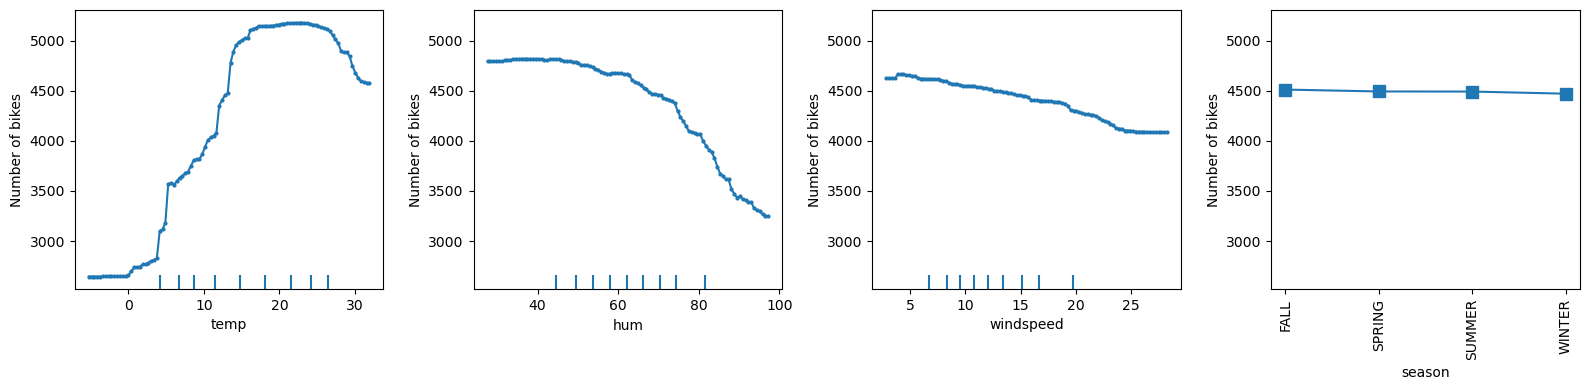

In [12]:
_=plot_pd(exp=exp,n_cols=4,fig_kw={'figheight':4, 'figwidth': 16},sharey='row')

다음은 `kind=both`로 지정하여 $ICE$와 $PD$를 동시에 보여준다. `n_ice`는 $ICE$의 출력개수를 지정하며 개수가 지정되면 개별 데이터들을 랜덤샘플링을 통해 추출하여 시각화한다. 만약 'all'로 지정하면 데이터 수만큼 $ICE$를 출력하게 된다.  
`center` 는 $ICE$ 곡선을 중심으로 정렬할지를 선택하는 옵션이다. 기본값은 False이며, True로 설정할 경우 각 $ICE$ 곡선의 절편을 중심으로 정렬시켜 곡선이 특정 변수의 변화에 어떻게 반응하는지 더 명확히 볼 수 있도록 한다.
절편 값이 크게 다를 경우, 전체 곡선의 변동성 패턴을 파악하기 어려울 수 있다. 이때 `center=True`로 설정하면, 곡선의 절편을 제거하고 변동성만을 시각화하게 된다.  
`sharey`는 $PD$와 $ICE$ 곡선의 y축을 동일한 스케일로 설정할 지를 설정한다. 주황색 선은 plot에 average라고 적혀있는데 이전에 언급한대로 $ICE$의 평균이 $PD$이므로 주황색 선은 $PD$를 보여준다.  

`n_col`과 `fig_kw`는 figure 크기와 subplot 조절 옵션이다. 더 자세한 옵션들은 plot_pd의 [API](https://docs.seldon.io/projects/alibi/en/latest/api/alibi.explainers.html#alibi.explainers.plot_pd)를 참고하면 된다.

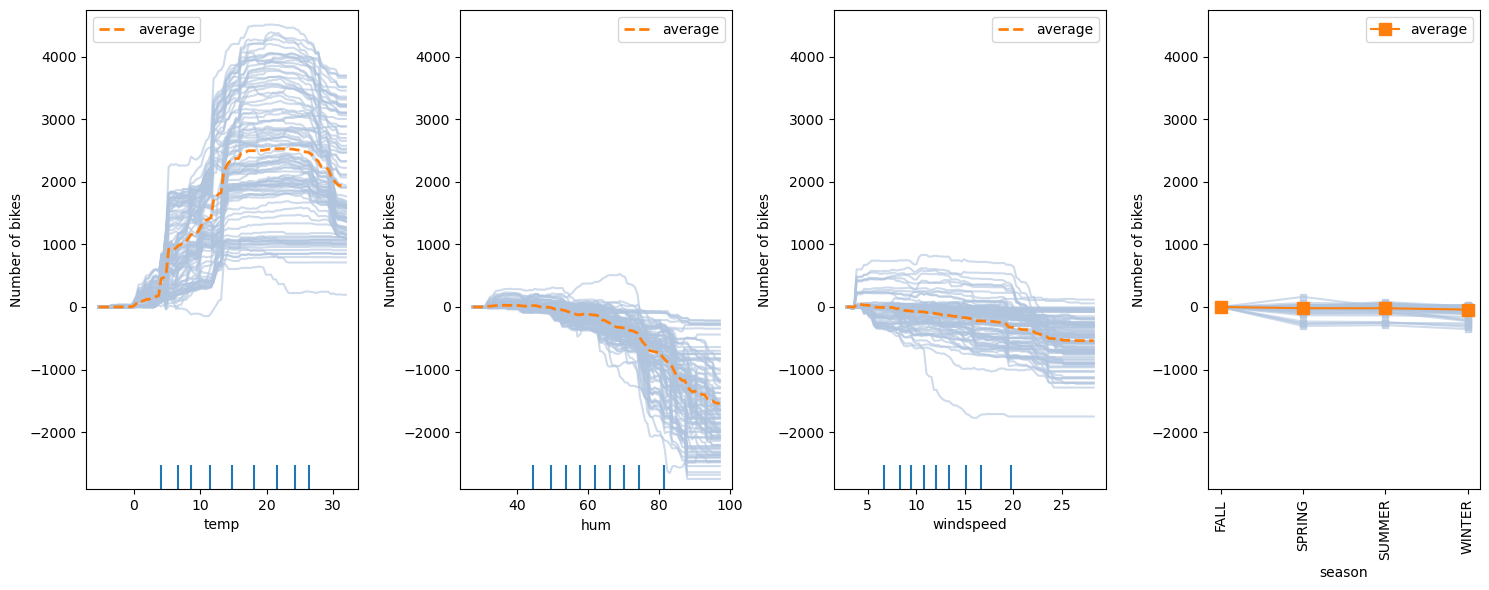

In [13]:
exp = explainer.explain(X=X_train,features=features,kind='both')
_=plot_pd(exp=exp,n_cols=4,n_ice=100,center=True,sharey='row',fig_kw={'figheight':6, 'figwidth': 15})

2개의 설명변수가 목적변수에 미치는 교호작용 $PD$를 살펴보기 위해 다음과 같이 관심있는 교호작용을 tuple로 묶어서 list로 정의하면 이들 변수 간의 교호작용 $PD$를 구할 수 있으며 데이터 형식의 구분없이 다양한 조합의 교호작용을 볼 수 있다.

In [14]:
features_interaction = [
    (feature_names.index('temp'), feature_names.index('windspeed')),  ## 온도 * 풍속
    (feature_names.index('mnth'), feature_names.index('weathersit')), ## 월 * 날씨 상태
    (feature_names.index('season'), feature_names.index('temp'))      ## 계절 * 온도
]

In [15]:
exp = explainer.explain(X=X_train,
                        features=features_interaction,
                        kind='average',
                        grid_resolution=25
                        )

다음과 같이 다양한 형태로 시각화가 가능하다. 먼저 첫 번째 plot을 보면 x축은 temp, y축은 windspeed이며 목적변수는 등고선(contour) 형태로 표현된 것을 확인할 수 있다. 온도가 12도 이하에서는 바람의 세기가 목적 변수에 거의 영향이 없지만 12~27도에서 바람의 세기가 20 이상이면 자전거 대여 수가 감소하는 것을 볼 수 있다.  
다음으로 월(month)과 날씨 상태 간의 교호작용을 보면 크게 유의미한 교호작용이 없으며 오직 날씨 상태에 따라 자전거 대여수에 유의미한 차이가 있어 보인다. 마지막으로 계절과 온도 사이에 교호작용을 보면 유의미한 교호작용이 있다고 하기 어렵다.  
<div style="text-align: center; color: gray;">시각화만 진행해서 결론을 내기보단 통계적인 검정도 같이 진행하여 인사이트를 추출하는게 안전하다.</div>


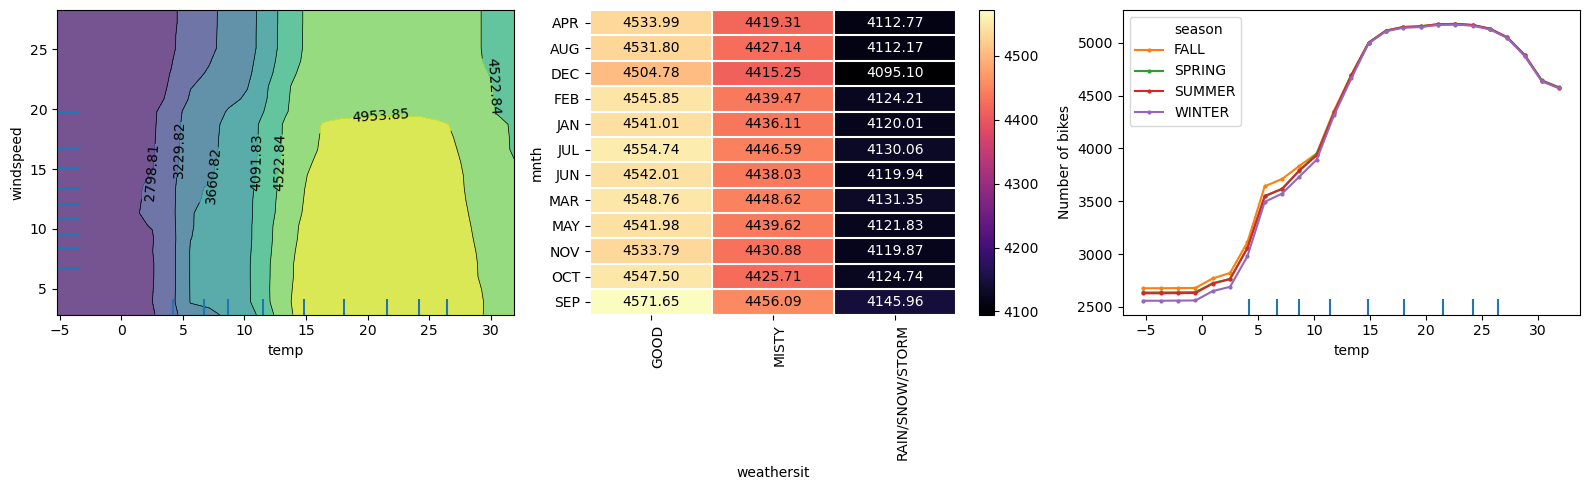

In [16]:
_=plot_pd(exp=exp,n_cols=3,fig_kw={'figheight':5,'figwidth':16})

`PartialDepedence` 모듈 외에도 sklearn에서 제공하는 트리 기반 모델에 대해서 더 빠르게 $PD$를 계산해주는 `TreePartialDependence` 모듈도 존재한다. 다만 `TreePartialDependence` 에서는 $ICE$를 구할 순 없다.

---

## PV : Partial Dependence Variance
다음은 PV를 적용하기 위해 `PartialDependenceVariance`를 호출하고 X_train 데이터를 이용하여 $PV$를 계산한다.

In [17]:
from alibi.explainers import PartialDependenceVariance
pd_variance = PartialDependenceVariance(predictor=prediction_fn,
                                        feature_names=feature_names,
                                        categorical_names=cat_names,
                                        target_names=target_names)

In [18]:
exp_importance_all = pd_variance.explain(X=X_train,method='importance')

다음은 plot_pd_variance를 이용하여 $PV$로 평가된 변수 중요도를 보여준다. `features`에 변수명을 지정하면 지정된 변수만의 중요도만 출력하여 시각화할 수 있다.

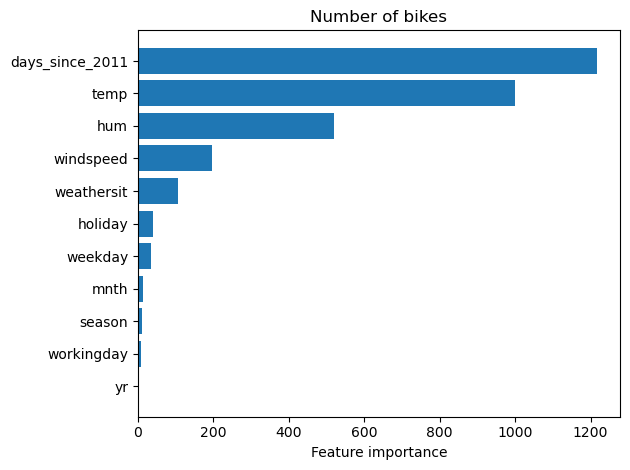

In [19]:
from alibi.explainers import plot_pd_variance
_=plot_pd_variance(exp=exp_importance_all)

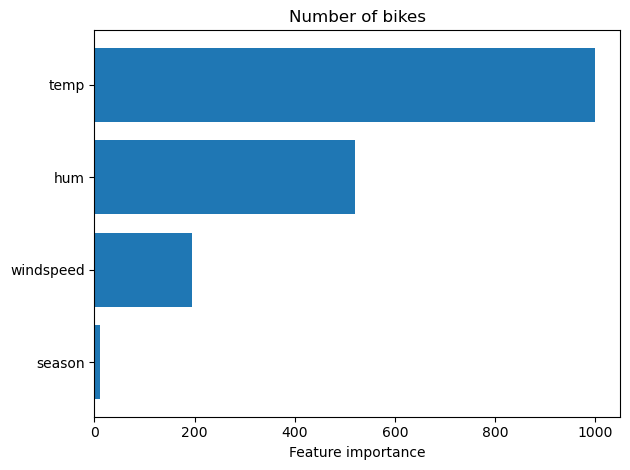

In [20]:
features = [feature_names.index('temp'),
            feature_names.index('hum'),
            feature_names.index('windspeed'),
            feature_names.index('season')]
exp_importance = pd_variance.explain(X=X_train,features=features,method='importance')
_=plot_pd_variance(exp=exp_importance)

`plot_pd_variance` 옵션에서 `summarize=False`로 지정하면 변수의 $PD$와 $PV$를 동시에 출력할 수 있다. 해당 변수의 plot title을 보면 $PV$가 적혀 있다.

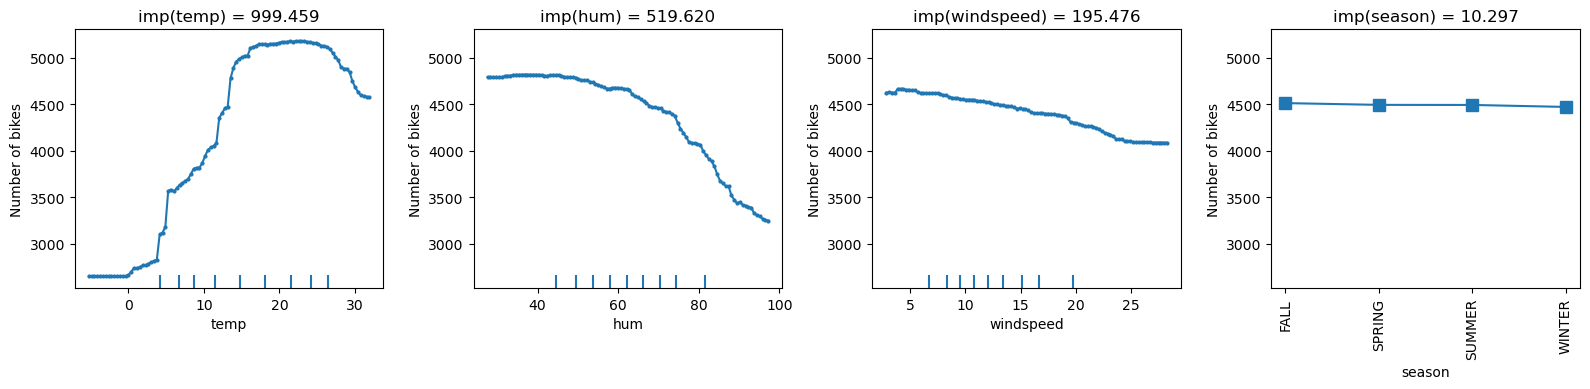

In [21]:
_=plot_pd_variance(exp=exp_importance,summarise=False,n_cols=4,fig_kw={'figheight':4, 'figwidth': 16})

`features`에 tuple로 짝지은 설명변수들을 지정하고 `method=interaction` 를 지정하면 짝지어진 변수 간 교호작용에 대한 $PV$를 구할 수 있다.

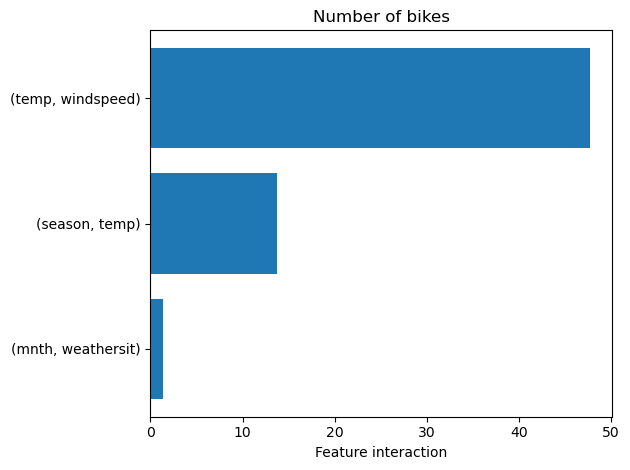

In [22]:
exp_interaction = pd_variance.explain(X_train,features=features_interaction,method='interaction')
_=plot_pd_variance(exp=exp_interaction)

같은 방법으로 `summarise=False`로 지정하면 교호작용에 대한 $PD$와 $PV$를 동시에 구할 수 있다.

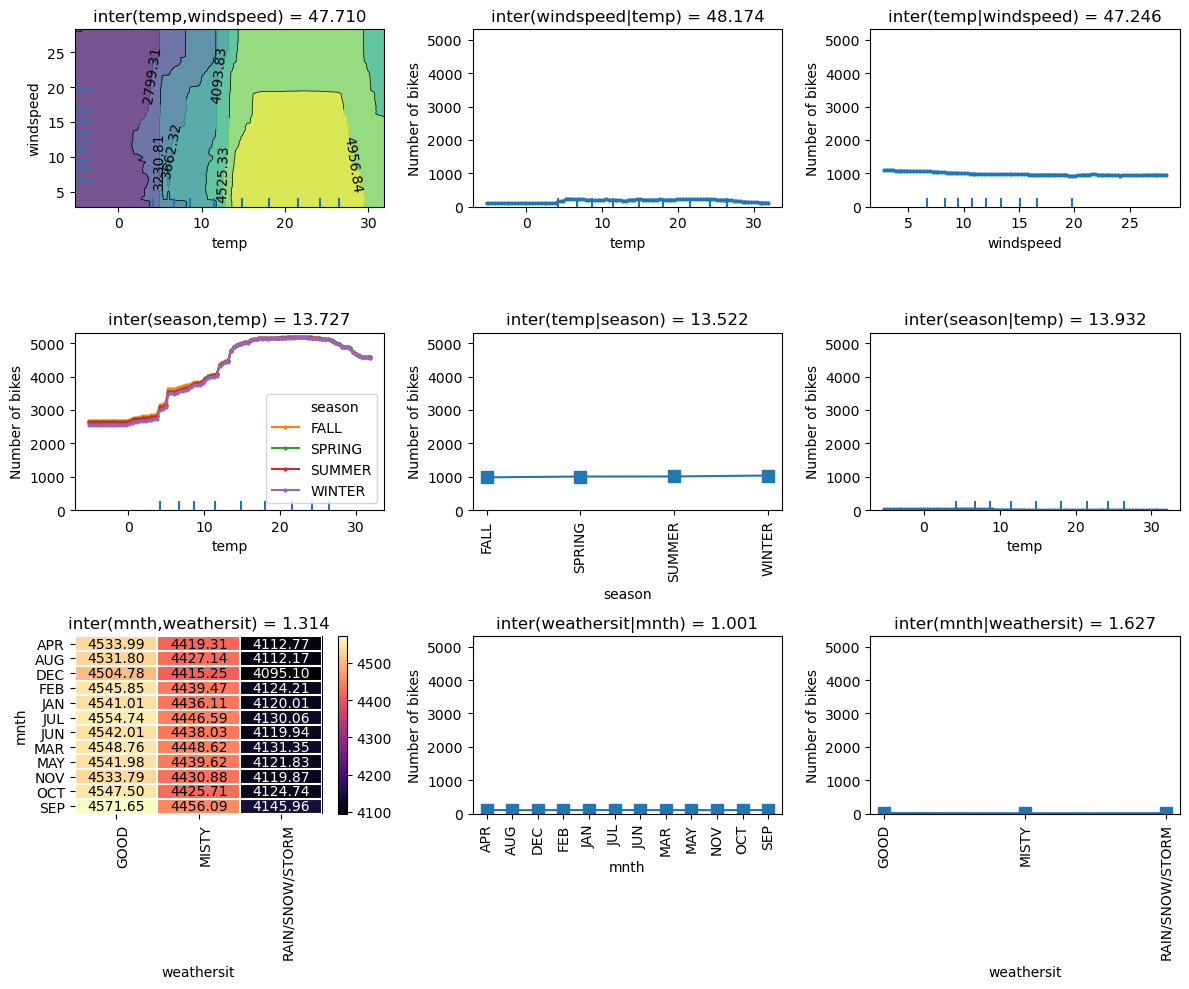

In [23]:
_=plot_pd_variance(exp=exp_interaction,summarise=False,fig_kw={'figheight':10, 'figwidth':12})

---

## ALE : Accumulated Local Effect
$ALE$는 설명변수가 실수형일 때만 적용할 수 있으므로 IRIS 데이터와 $ALE$와 $PD$를 비교하기 위한 모듈을 불러온다.

In [45]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from alibi.explainers import ALE,plot_ale,PartialDependence,plot_pd,PartialDependenceVariance

다음과 같이 설명변수와 목적변수 명을 정의하고 학습데이터와 시험데이터를 분리한다.

In [25]:
data=load_iris()
feature_names = data.feature_names
target_names = data.target_names

In [30]:
X=data.data
y=data.target

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

#### 로지스틱 선형회귀

학습데이터 X_train을 로지스틱 회귀모형에 적합하고 성능을 점검한 후, 예측함수를 3개의 class에 속할 확률과 logit 값(decision_function)으로 지정하여 각각을 동기화한다. logit 값을 지정한 이유는 설명변수가 logit값에 선형인지 확인하기 위함이다.

In [34]:
lr = LogisticRegression(max_iter=200)
lr.fit(X_train,y_train)
accuracy_score(y_test,lr.predict(X_test))

1.0

In [35]:
prob_ale_lr = ALE(lr.predict_proba,feature_names=feature_names,
                  target_names=target_names)

logit_ale_lr = ALE(lr.decision_function,feature_names=feature_names,
                   target_names=target_names)

In [36]:
prob_exp_lr = prob_ale_lr.explain(X_train)
logit_exp_lr = logit_ale_lr.explain(X_test) 

다음처럼 설명변수 Petal length(features=[2])가 각 class에 속할 확률에 미치는 영향을 plot_ale로 살펴볼 수 있다. 예를 들어, setosa에 속할 확률은 petal length가 1.7에서 3.7로 증가하면 선형적으로 감소하다가 3.7 이상이면 확률의 변동이 거의 없는 것을 관측할 수 있다.

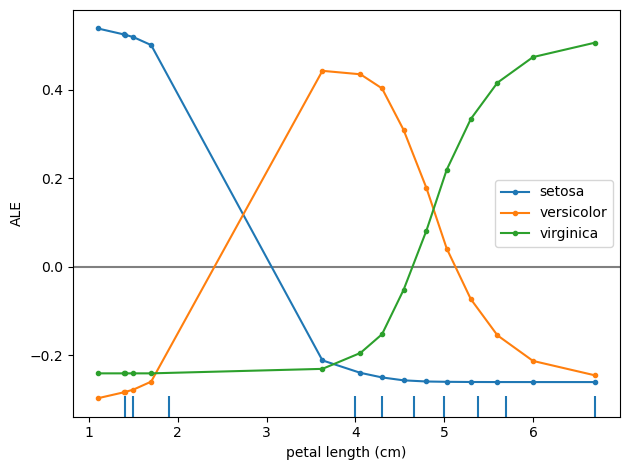

In [38]:
_=plot_ale(prob_exp_lr,features=[2])

다음 그림과 같이 예측함수가 logit이면 설명변수와 목적변수 logit 값의 관계가 선형임을 알 수 있다.

array([[<Axes: xlabel='petal length (cm)', ylabel='ALE'>]], dtype=object)

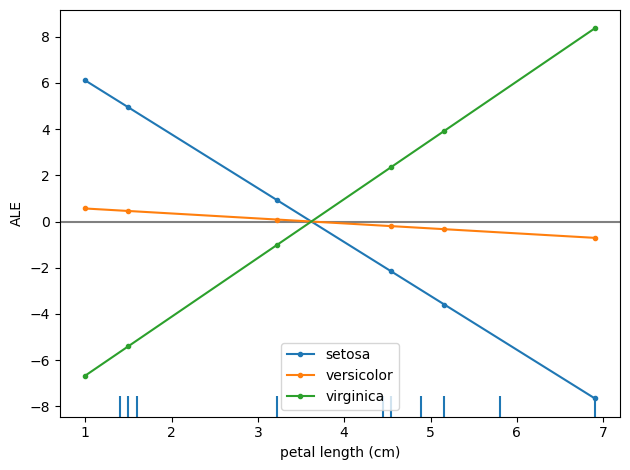

In [39]:
plot_ale(logit_exp_lr,features=[2])

다음은 $ALE$와 $PD$를 비교하기 위해 예측함수를 `lr.predict_proba`로 지정한 후, 설명변수 petal length에 대해 각 class 별로 $PD$를 그려준다.

In [40]:
explainer_pd = PartialDependence(predictor=lr.predict_proba,
                                 feature_names=feature_names,target_names=target_names)
exp_pd = explainer_pd.explain(X=X_train,kind='average')

참고로 아래의 `plot_pd` 옵션의 `target` 은 `plot_ale`와 다르게 오직 하나의 class만 지정하게 되어 있으므로 주의해야 한다. 다음은 각 변수별(row)로 class 확률(col)을 그린 plot이다.

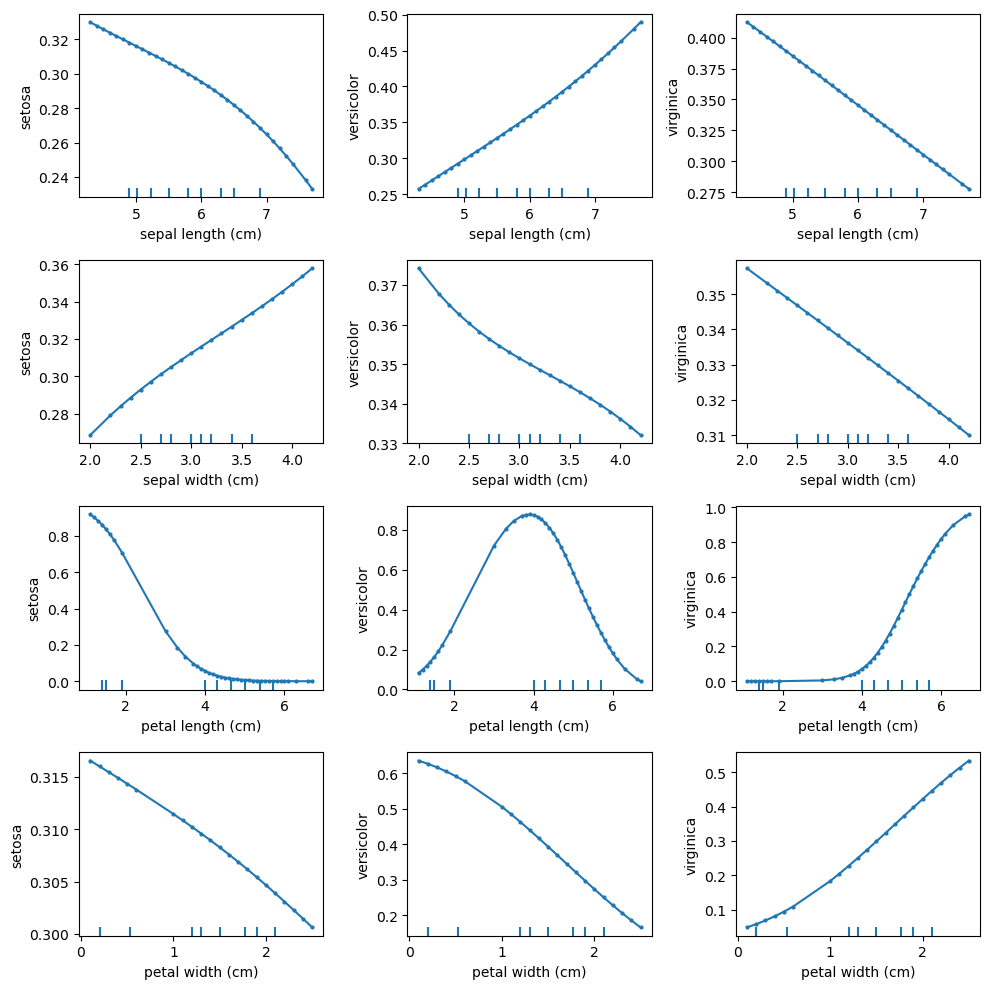

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 3, figsize=(10, 10))  # 4행 3열, 전체 크기 조정

# 4개의 변수(features)와 3개의 타겟(target)에 대해 반복
for feature_idx, row_axes in enumerate(axes):  
    for target_idx, ax in enumerate(row_axes):  
        plot_pd(exp=exp_pd, target=target_idx, features=[feature_idx], ax=ax)

plt.tight_layout()  
plt.show()


다음은 $PV$를 이용한 각 class 별 설명변수 중요도를 보여준다. class에 상관없이 petal_length가 가장 중요한 설명변수임을 보여준다.

In [54]:
pd_variance=PartialDependenceVariance(predictor=lr.predict_proba,
                                      feature_names=feature_names,target_names=target_names)
exp_importance = pd_variance.explain(X=X_train,method='importance')

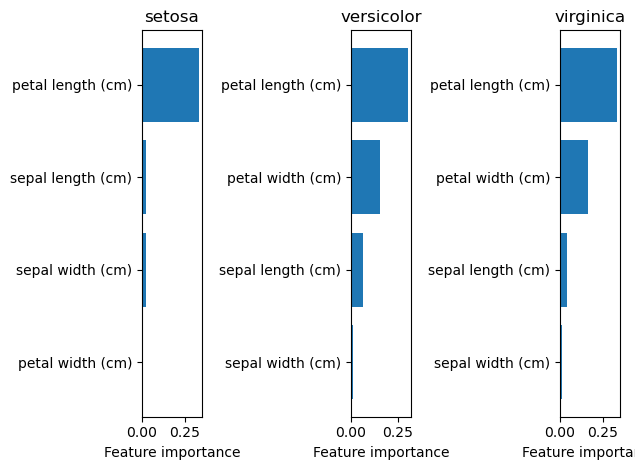

In [65]:
from alibi.explainers import plot_pd_variance
_=plot_pd_variance(exp=exp_importance,targets=[0,1,2])


#### Grdient Boosting

이번엔 동일한 데이터에 비선형모형인 Gradient Boosting 모형을 적합해본다.

In [66]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(X_train,y_train)

accuracy_score(y_test,gb.predict(X_test))

1.0

$ALE$에 부스팅 모형의 예측함수를 정의하고 동기화 한 후, logit 예측함수를 이용하여 class별 설명변수의 $ALE$를 보인다. 로지스틱과 다르게 비선형관계를 보여준다.

In [67]:
logit_ale_gb = ALE(gb.decision_function,feature_names=feature_names,
                   target_names=target_names)

prob_ale_gb = ALE(gb.predict_proba,feature_names=feature_names,
                  target_names=target_names)

logit_exp_gb = logit_ale_gb.explain(X_train)
prob_exp_gb = prob_ale_gb.explain(X_train)

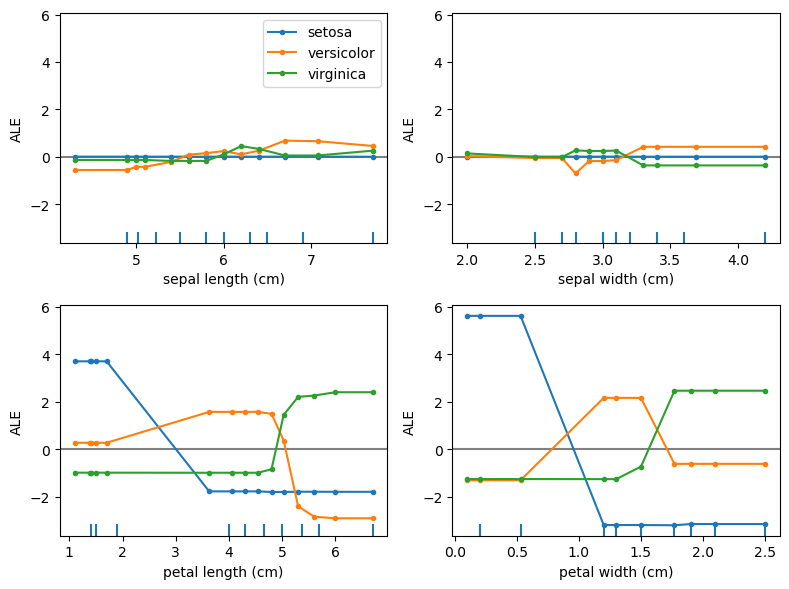

In [73]:
_=plot_ale(logit_exp_gb,n_cols=2,fig_kw={'figwidth':8,'figheight':6})

다음은 부스팅 모형에서 제공하는 변수 중요도이다. 이 중요도는 ELI5에서도 동일한 결과를 산출할 수 있다. class와 관계없이 petal_length가 중요한 변수이가, petal_width가 두 번쨰로 중요한 변수임을 보여준다. 하지만 이런 변수 중요도는 class별로 제공하지 않으므로 $PV$를 이용하여 class별로 구해야한다.

In [74]:
print(gb.feature_importances_)

[0.00223883 0.01518582 0.56459182 0.41798353]


다음은 예측함수가 setosa에 속할 확률일 때, 로지스틱 모형과 부스팅 모형의 $ALE$를 비교한다.

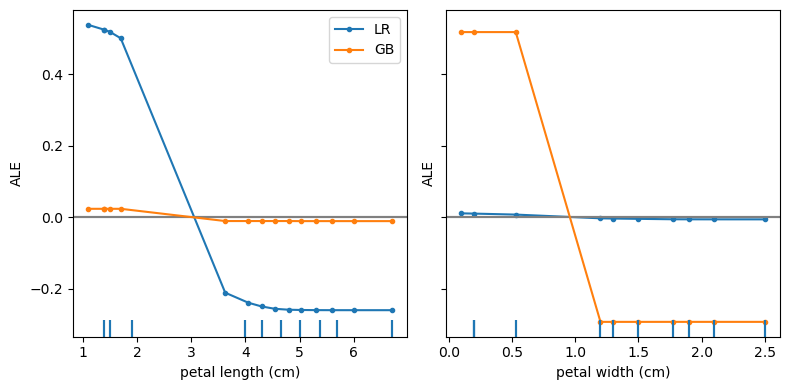

In [78]:
fig, ax =plt.subplots(1,2,figsize=(8,4),sharey='row')
plot_ale(prob_exp_lr, features=[2,3],targets=['setosa'],ax=ax,line_kw={'label':'LR'})
plot_ale(prob_exp_gb, features=[2,3],targets=['setosa'],ax=ax,line_kw={'label':'GB'})
plt.show()

다음은 부스팅 모형의 예측함수로부터 구한 설명변수 $PD$를 보인다. $PD$는 대응하는 $ALE$와 비교할 때 차이가 있음을 알 수 있다. $PD$는 설명변수가 독립이라는 가정에서 구하기 때문에 이러한 차이가 발생한다.

In [87]:
prob_pd_gb = PartialDependence(gb.predict_proba,feature_names=feature_names,
                               target_names=target_names)

prob_pd_exp_gb = prob_pd_gb.explain(X_train)

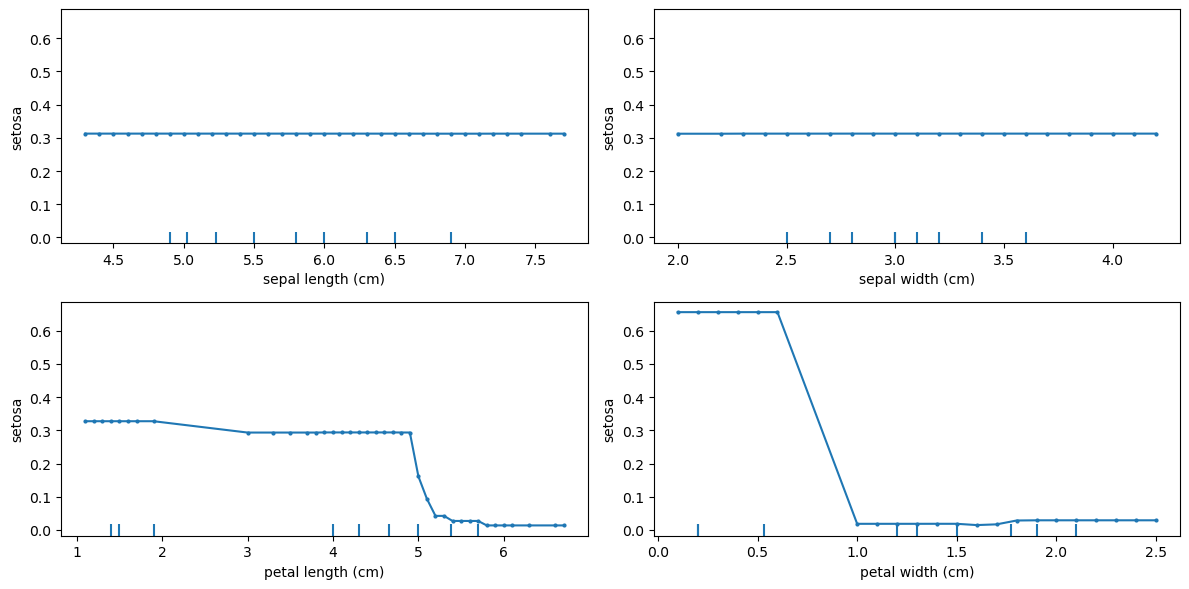

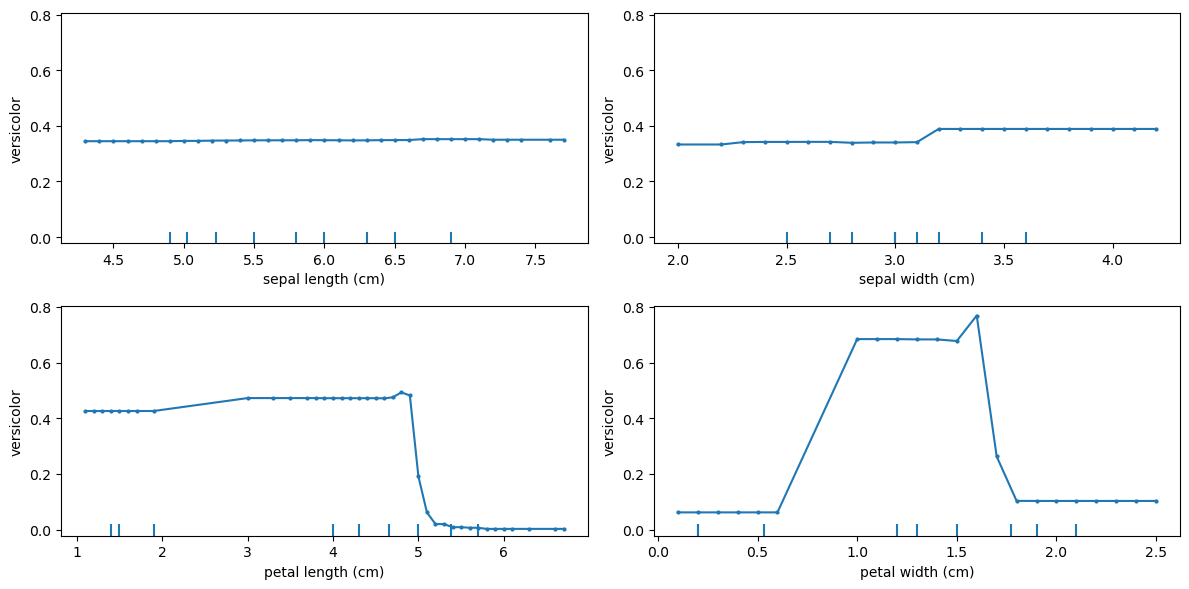

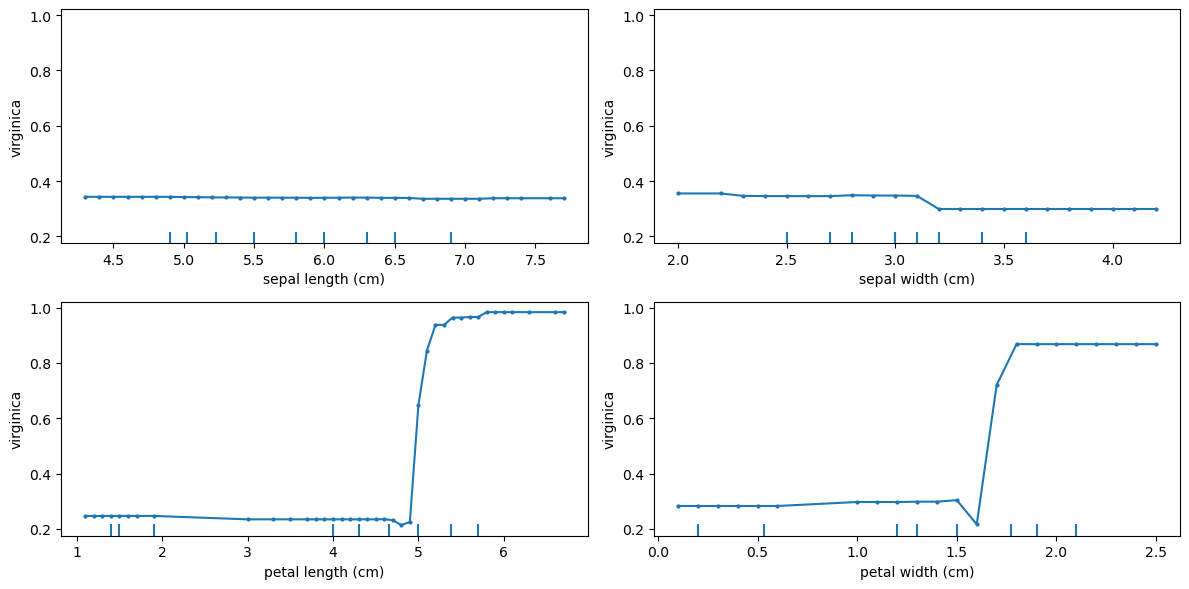

In [88]:
for i in range(3):
    plot_pd(prob_pd_exp_gb,n_cols=2,target=i,fig_kw={'figwidth':12,'figheight':6})

---

## PI : Permutation Importance
다음은 설명변수 중요도를 $PI$로 산출하기 위해 필요한 모듈을 호출하고 있다.

In [24]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score

from alibi.explainers import PermutationImportance, plot_permutation_importance

$PI$를 적용하기 위한 데이터는 일의 만족도, 평가, 봉급 등의 9개 설명변수로 목적변수인 이직여부(left)를 예측하기 위한 데이터이다. 9개의 설명변수 중 4개는 범주형이고 5개는 수치형으로 구성되어 있다.

In [25]:
url='https://raw.githubusercontent.com/RuchitaGarde/Human-Resources-Analytics/master/HR_comma_sep.csv'


df=pd.read_csv(url)
df.head()

,left,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,satisfaction_level,promotion_last_5years,sales,salary
0,1,0.53,2,157,3,0,0.38,0,sales,low
1,1,0.86,5,262,6,0,0.80,0,sales,medium
2,1,0.88,7,272,4,0,0.11,0,sales,medium
3,1,0.87,5,223,5,0,0.72,0,sales,low
4,1,0.52,2,159,3,0,0.37,0,sales,low


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   left                   14999 non-null  int64  
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   satisfaction_level     14999 non-null  float64
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


explainer를 적용하기 위해 설명변수와 목적변수의 이름, 그리고 범주형 변수의 인덱스를 아래와 같이 정의한다.

In [27]:
target_name = 'left'
feature_names = df.columns.to_list()
feature_names.remove(target_name)
cat_names = ['Work_accident','promotion_last_5years','sales','salary']
num_names = [ft for ft in feature_names if ft not in cat_names]
cat_indices = [feature_names.index(ft) for ft in cat_names]

이직(left=1)인 경우가 전체의 23.81%로 소수 클래스이므로 모형적합 시 이런 불균형 문제를 고려해야 하며 모형의 성능이 데이터의 imbalance에 영향을 덜 받기 위해서는 성능측정을 accuracy 대신 precision,recall 또는 f1을 사용해야 한다.

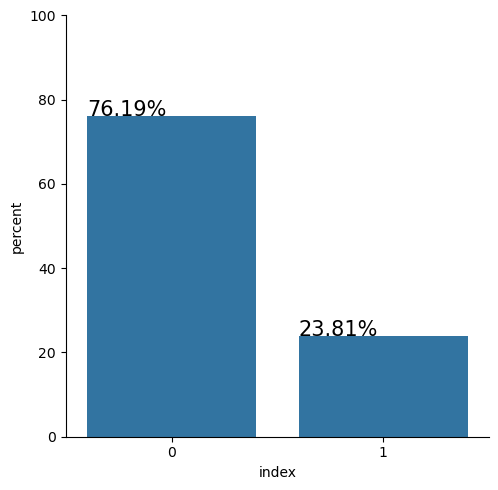

In [28]:
target_perc =df[target_name].value_counts(normalize=True). mul( 100). rename('percent'). reset_index()

g = sns.catplot(data=target_perc, x='index', y='percent', kind='bar')
g.ax.set_ylim(0, 100)
for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x, txt_y = p.get_x(), p.get_height()
    g.ax.text(x=txt_x, y=txt_y, s=txt, fontdict={'size': 15})

`alibi`의 explainer는 `numpy` 데이터를 입력 받아야하므로 `pandas` 데이터를 `numpy` 데이터로 변환 후 학습데이터와 시험데이터로 분리한다.

In [29]:
X=df[feature_names].to_numpy()
y=df[target_name].to_numpy()

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=0)

다음과 같이 범주형 변수를 one-hot encoding하기 위해 `ColumnTransformer`를 적용한다. 수치형 변수는 그대로 사용하기 때문에 `remainder='passthrough'`를 지정하고 있다. default는 `reminder='drop'`이며 이 경우 모든 수치형 변수가 제거되므로 반드시 변경해야 한다.

In [35]:
preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(sparse=False, drop='if_binary', handle_unknown='ignore'), cat_indices)],
    remainder='passthrough')

다음과 같이 `ColumnTransformer`를 적용하여 변환한 데이터를 randomforest 모델에 적합한 후, 학습데이터와 시험데이터에서 모형의 성능을 점검한다.

In [36]:
preprocessor = preprocessor.fit(X_train)
x_train_ohe = preprocessor.transform(X_train)
X_test_ohe = preprocessor.transform(X_test)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [39]:
rf = RandomForestClassifier(class_weight='balanced',random_state=0)
rf = rf.fit(x_train_ohe,y_train)

y_train_hat = rf.predict(x_train_ohe)
print(classification_report(y_true=y_train,y_pred=y_train_hat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9142
           1       1.00      1.00      1.00      2857

    accuracy                           1.00     11999
   macro avg       1.00      1.00      1.00     11999
weighted avg       1.00      1.00      1.00     11999



In [40]:
y_test_hat =rf.predict(X_test_ohe)
print(classification_report(y_true=y_test,y_pred=y_test_hat))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2286
           1       1.00      0.96      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.99      3000
weighted avg       0.99      0.99      0.99      3000



$PI$를 적용하기 위한 예측함수를 다음과 같이 정의한다.

In [41]:
def predict_fn(X: np.ndarray) -> np.ndarray:
    return rf.predict(preprocessor.transform(X))

$PI$를 동기화하고 loss_fns를 생략한 대신 `score_fn=['accuaracy','f1']`으로 부여하여 $PI$를 2개의 score로 계산하도록 한다. 그러므로 $e_{switch}=e_{org}+score$ 감소량으로 정의된다.

In [42]:
explainer = PermutationImportance(predictor=predict_fn,score_fns=['accuracy','f1'],
                                  feature_names=feature_names,verbose=True)

exp = explainer.explain(X=X_test,y=y_test)

100%|██████████| 9/9 [00:35<00:00,  3.97s/it]


다음은 accuarcy와 f1으로 계산된 $PI$값으로 설명변수의 중요도를 산출한다. 두 성능지표는 설명변수의 중요도가 동일하게 나오며, sales,salary,accident, 그리고 promotion_last_years는 $PI$값이 모두 1값을 보이고 있어 모형의 accuracy나 f1을 높이는데 전혀 기여하지 못하는 것으로 나타난다. 

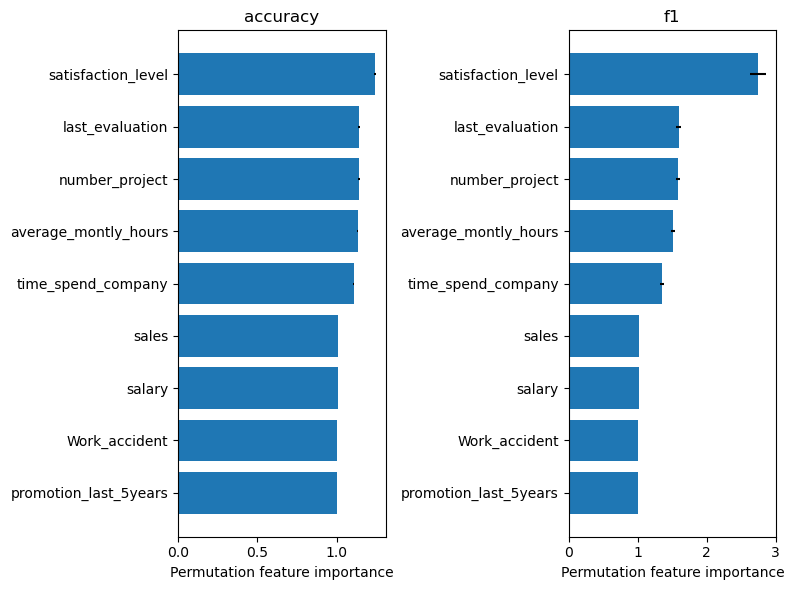

In [44]:
_=plot_permutation_importance(exp,n_cols=2,fig_kw={'figwidth':8,'figheight':6})

$PI$를 계산하기 위한 손실함수나 score는 맞춤형으로 정의하여 사용할 수도 있다. 다음은 $PI$를 구하기 위해 1-f1을 손실함수로 정의하고 있다.

In [45]:
def loss_f1(y_true:np.ndarray,y_pred:np.ndarray)->float:
    return 1-f1_score(y_true=y_true, y_pred=y_pred)

In [47]:
explainer_loss_f1 = PermutationImportance(predictor=predict_fn,
                                          loss_fns={'1-f1':loss_f1},feature_names=feature_names,
                                          verbose=True)
explainer_loss_f1 = explainer_loss_f1.explain(X=X_test,y=y_test)

100%|██████████| 9/9 [00:37<00:00,  4.12s/it]


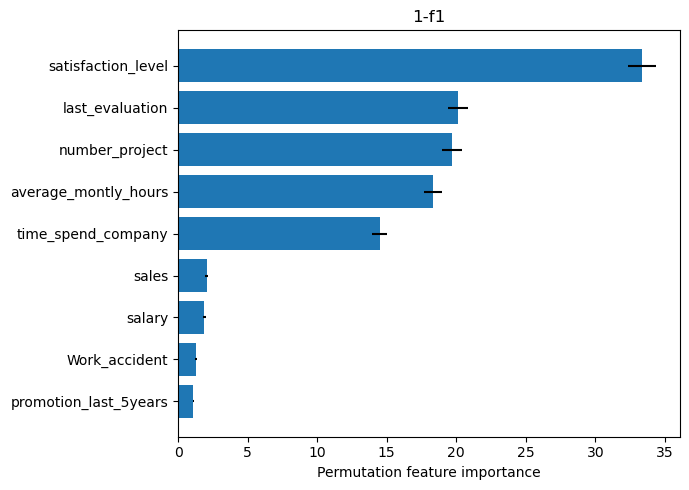

In [49]:
_=plot_permutation_importance(exp=explainer_loss_f1,fig_kw={'figwidth':7,'figheight':5})